# Initial Condition Sensitivity Analysis
Analyze the sensitivity of the filament dynamics to Initial Conditions.

Procedure:
- Start with a simulation after transients are over.
- Choose random points corresponding to different phase and time values. 
- For each point choose O(100) nearby points by adding a random perturbation to the filament shape.
- Simulate the dynamics starting with these IC over a further N cycles.
- For each pair of closely separated IC, calculate the pair-wise Euclidean distance between the filament shapes.
- Plot the change in this pair-wise distance over time and average over all ICs (closely separed). Also average over many different ICs

In [2]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import interpolate
import h5py


import os
from sys import platform

from joblib import Parallel, delayed
import multiprocessing

import pyfilaments.analysisutils as analysis
from pyfilaments.activeFilaments import activeFilament

import imp
imp.reload(analysis)
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

# Check which platform
if platform == "linux" or platform == "linux2":
    print("linux system")
    # root_path = '/home/deepak/Dropbox/LacryModeling/ModellingResults'
    root_path = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults'

elif platform == 'darwin':
    print("OSX system")
    root_path = '/Users/deepak/Dropbox/LacryModeling/ModellingResults'
    
publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure3'

if(not os.path.exists(publication_figures)):
    os.makedirs(publication_figures)

linux system


## Load a filament simuation where transients have decayed

In [21]:
# Aperiodic
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 2
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 2 (higher activity)
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.9743589743589742_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 4
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 6
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/SimResults_01.hdf5'

# Period 10
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point/SimResults_00.hdf5'

# Aperiodic higher activity
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.6794871794871793_activityTime_750_simType_point/SimResults_00.hdf5'

# Constant activity
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ConstantCompressiveActivity_sweep/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/SimResults_00_.hdf5'

#-------------------------------------------------------------------------------------------------------------------

# New simulations (wider range of ICs)
# Aperiodic
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/IC_analysis_subset/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point/SimResults_00_.hdf5'
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/SimResults_01_.hdf5'

# Period 2
file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/IC_analysis_subset/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point/SimResults_00_.hdf5'

# period 2 (high activity)
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.038_activityTime_750_simType_point/SimResults_03_.hdf5'

# Period 1
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.013_activityTime_750_simType_point/SimResults_00_.hdf5'
fil = analysis.analysisTools(file = file)
ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')
    
fil.ic_analysis_folder = ic_analysis_folder


<IPython.core.display.Javascript object>


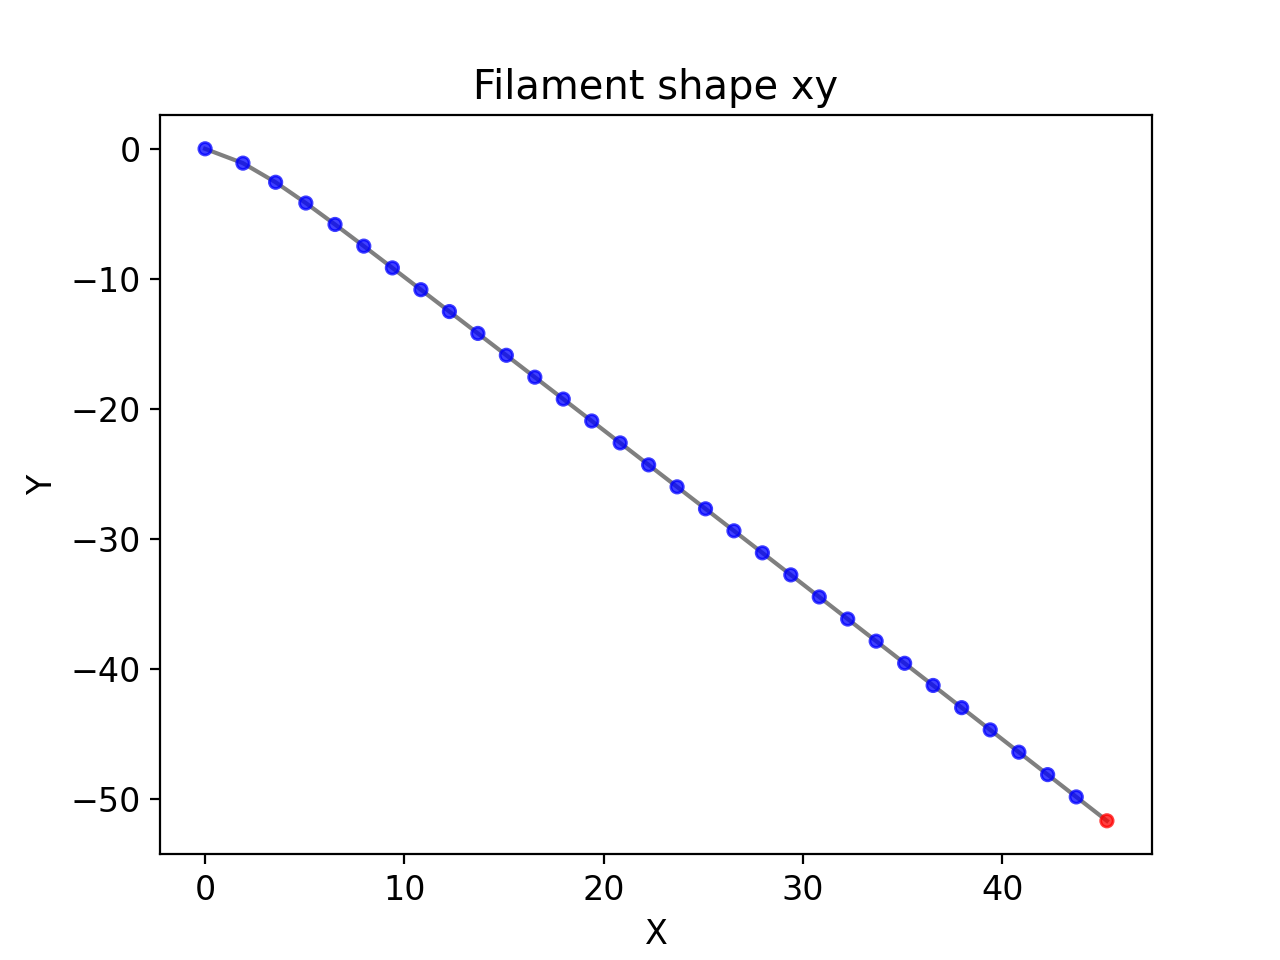

In [135]:
final_shape = fil.R[-1,:]
plt.figure()
fil.plotFilament(r = final_shape)

## Choose ICs after transients have decayed

In [22]:
# Function version of above script
import random 
# Global parameters
DELTA_IC = 1e-12 # Average distance between nearby ICs.

N_transient = 400 # No:of activity cycles for transients to decay. 

N_IC_time = 10 # IC based on different activity cycles/time
N_IC_phase = 1 # Different IC within each activity phase

N_IC_nearby = 10

N_ACTIVITY_CYCLES = 50 # No:of activity cycles to simulate for IC sensitivity analysis

def choose_ic_time_phase(fil):
    """Takes a filament simulation and returns randomly chosen time points at a randomly chosen phase
        along the activity cycle.
    """
    
    N_cycles = int(fil.Time[-1]/fil.activity_timescale)

    # Choose n random activity cycles (time)
    n_cycles = random.sample(range(N_transient, N_cycles), N_IC_time)

    print(n_cycles)

    # Within each activity cycle choose points evenly distributed in phase
    n_phase = random.sample(list(np.linspace(0, 2*np.pi, 100)), N_IC_phase)

    print(n_phase)

    # Compute the minimum resolved phase difference in the simulations
    delta_phase = 2*np.pi*np.mean(fil.Time[1:] - fil.Time[:-1])/fil.activity_timescale # Smallest change in phase

    time_points = np.array(range(0, len(fil.Time)))
    # Find the index corresponding to each unique IC

    # Create empty array to store indices for each unique IC

    ic_mesh = np.empty((N_IC_time, N_IC_phase), dtype = int)

    # Phase array for the whole simulation
    phase_array = 2*np.pi*(fil.Time%fil.activity_timescale)/fil.activity_timescale


    for ii, phase in enumerate(n_phase):

        print(phase)
        print(fil.derived_data['Phase'])
        abs_val_array = np.abs(fil.derived_data['Phase'] - phase)
        constant_phase_mask = abs_val_array <= 0.5*delta_phase
        time_indices = time_points[constant_phase_mask]
        ic_mesh[:, ii] = time_indices[n_cycles]
        
    return ic_mesh


In [23]:
ic_mesh = choose_ic_time_phase(fil)

[410, 434, 455, 448, 478, 432, 405, 411, 446, 487]
[5.838919679399211]
5.838919679399211
[0.         0.0837758  0.16755161 ... 6.1156337  6.1994095  0.        ]


# Generate Filament Initial Conditions and Store them
For each IC generated above, generate N nearby initial conditions and save the resulting filament shapes $\delta$

- Save the generated filament shape ICs to disk (in a sub-folder of the original sim data)
    eg. /SimResults/IC_analysis
- Save each unique IC in a separate folder
    eg./SimResults/IC_analysis/IC_{index}
- Within that folder the results from the

In [24]:
# Function version of above script

def generate_close_ic(fil = None, ic_mesh = None, rn_seed = 0):
    """ Start with a filament shape at the randomly chosen time-points and generate closely spaced ICs 
        by adding random perturbation with a small amplitide \delta_IC
        
        Store these ICs as .hdf5 files in the IC_analysis folder within the simulation data folder.
        
        Returns: Nothing
    """
    if not(os.path.exists(fil.ic_analysis_folder)):
           os.makedirs(fil.ic_analysis_folder)
    # Use a fixed seed to generate repeatable random numbers
    np.random.seed(rn_seed)

    filament_init_shape = np.zeros(fil.Np*fil.dim, dtype = np.double)

    delta_theta_array = DELTA_IC*np.random.randn(N_IC_nearby)
    
    phase_array = 2*np.pi*(fil.Time%fil.activity_timescale)/fil.activity_timescale

    
    
    for ii in range(N_IC_time):

        for jj in range(N_IC_phase):

            time_index = ic_mesh[ii, jj]

            phase = phase_array[time_index]

            ic_folder = os.path.join(fil.ic_analysis_folder, 'IC_{}'.format(time_index))

            if(not os.path.exists(ic_folder)):
               os.makedirs(ic_folder)

            filament_shape = fil.R[time_index,:]
#             plt.figure(figsize=(2,2))
#             fil.plotFilament(r = filament_shape)
#             plt.title(time_index)
#             plt.axis('equal')

            for kk in range(N_IC_nearby):
                #-------------------------------
                # Method 1 : Random transverse perturbation
                #-------------------------------
                 # Add noise along X direction
                filament_init_shape[1:fil.Np] = \
                filament_shape[1:fil.Np]+ np.random.normal(0, DELTA_IC, fil.Np-1)
                # Add noise along Y direction
                filament_init_shape[fil.Np+1:2*fil.Np] = \
                filament_shape[fil.Np+1:2*fil.Np]+ np.random.normal(0, DELTA_IC, fil.Np-1)
                #-------------------------------
                # Method 2 : Add a solid body rotation.
                #-------------------------------
    #             delta_theta = delta_theta_array[kk]

    #             x_pos = filament_init_shape[0:fil.Np]
    #             y_pos = filament_init_shape[fil.Np:2*fil.Np]

    #             delta_x = -delta_theta*y_pos
    #             delta_y = delta_theta*x_pos

    #             filament_init_shape[0:fil.Np] = filament_shape[0:fil.Np] + delta_x
    #             filament_init_shape[fil.Np:2*fil.Np] = filament_shape[fil.Np:2*fil.Np] + delta_y
    
                save_file = 'filament_ic_{0:03d}.hdf5'.format(kk)
                # Save the resulting filament shapes to disk
                with h5py.File(os.path.join(ic_folder, save_file), "w") as f:

                    dset = f.create_group("simulation data")
                    dset.create_dataset("Initial Position", data = filament_init_shape)
                    dset.attrs['Time index'] = time_index
                    # Also save the phase value of the simulation
                    dset.attrs['Phase'] = phase
                    

In [25]:
generate_close_ic(fil, ic_mesh)

# Run Simulations with the Closely Spaced ICs as starting points


In [26]:
def create_batchsim_table(folders = None, fil = None):
    
    """ Create a table/dict of IC for filament shape along with phase info that can be passed to run a Parallel job
        
        Input: Folder containing IC files. This folder should contain IC that are closely spaced together. 
        
        Returns: ic_list (dict containing: path, filename, filament shape and phase of each IC)
    
    """
    # Create a dictionary to store all IC we want to simulate
    ic_table = {}
    ic_counter = 0
    
    root_folder = fil.ic_analysis_folder
    
    
    
    if not(os.path.exists(fil.ic_analysis_folder)):
           os.makedirs(fil.ic_analysis_folder)

    for folder in folders:

        ic_files = os.listdir(os.path.join(root_folder, folder))
     
        for file in ic_files:
            
            if(file.endswith('.hdf5')):
                with h5py.File(os.path.join(root_folder, folder, file), "r") as f:
                    if('simulation data' in f.keys()): # Load the simulation data
                        dset = f['simulation data']
                        r = np.array(dset["Initial Position"][:])
                        time_point = int(dset.attrs["Time index"])
                        phase = dset.attrs['Phase']


                ic_table[ic_counter] = {'path':os.path.join(root_folder, folder), 'ic':file[:-5], 'filament shape':r, 'phase':phase}


                ic_counter+=1
            
    return ic_table

In [27]:
# Specify the folders as absolute path

folders = ['IC_30445']



ic_table = create_batchsim_table(folders, fil)

print(ic_table)

{0: {'path': '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/IC_analysis_subset/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point/IC_analysis/IC_30445', 'ic': 'filament_ic_006', 'filament shape': array([ 0.        ,  2.13843393,  4.27047393,  6.39719644,  8.5193519 ,
       10.63691393, 12.74917011, 14.85488142, 16.95240297, 19.03977288,
       21.11477846, 23.17502854, 25.21805079, 27.24139402, 29.24271998,
       31.21990628, 33.17116339, 35.09512426, 36.99089498, 38.85810579,
       40.69696025, 42.50823234, 44.29322242, 46.05373332, 47.79204999,
       49.51087622, 51.21322616, 52.90256387, 54.58209591, 56.2586086 ,
       57.92446435, 59.65295183,  0.        ,  0.14094637,  0.36106561,
        0.62991423,  0.93444737,  1.2710278 ,  1.64094346,  2.04787673,
        2.49646598,  2.99147712,  3.53731599,  4.13773851,  4.79568416,
        5.51318684,  6.29133504,  7.13027696,  8.02926892,  8.98674748,
       10.00

In [221]:
ic_table

{0: {'path': '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_36457',
  'ic': 'filament_ic_006.hdf5',
  'filament shape': array([ 0.00000000e+00,  2.07851507e+00,  4.14742863e+00,  6.01093475e+00,
          7.34197737e+00,  7.85552696e+00,  7.57458191e+00,  6.67089622e+00,
          5.47095987e+00,  4.20469325e+00,  2.98694707e+00,  2.11634050e+00,
          1.64598229e+00,  1.63010698e+00,  1.99751981e+00,  2.60410432e+00,
          3.26004880e+00,  3.85238533e+00,  4.22554391e+00,  4.34842136e+00,
          4.26785166e+00,  4.04402954e+00,  3.82711425e+00,  3.75001132e+00,
          3.79928555e+00,  4.01679713e+00,  4.32769632e+00,  4.65156770e+00,
          4.90361471e+00,  5.06797123e+00,  5.13613380e+00,  5.17825015e+00,
          0.00000000e+00, -2.21497114e-02,  3.04705288e-01,  1.22565337e+00,
          2.83506823e+00,  4.83545329e+0

# Run a parallel simulation using all the ICs that we have generated

In [28]:
def run_ic_simulation_batch(fil = None, ic_table = None):
    """ Runs a batch/parallel simulation on a set of N_IC closely spaced ICs specified using ic_table 
        for a given filament
        Inputs: filament object containing the filament corresponding to the current parameter value
                ic_table: List of ICs to simulate
                
        Returns: Nothing. Saves results of the IC simulations to disk.
    """
    #-----------------------------------------------------------------------------------------------------
    def run_ic_simulation(ic, path, filament_shape, phase):
#     """Run a filament simulation using specified parameters
#     """
        # Simulate each IC
        new_fil = activeFilament(dim = dim, Np = Np, radius = radius, b0 = b0, k = k, S0 = S0, D0 = D0, bc = bc)

        new_fil.simulate(Tf, Npts, n_cycles = n_activity_cycles, save = True, overwrite = False, path = path, sim_type = 'point', 
        init_condition = {'filament':filament_shape}, 
        activity={'type':'square-wave','activity_timescale':activity_timescale, 'duty_cycle':0.5, 'start phase':phase},
                     note = ic, create_subdirs=False, ic_sim = True)
    #-----------------------------------------------------------------------------------------------------
    # No:of activity cycles we want to simulate
    n_activity_cycles = N_ACTIVITY_CYCLES
    # Total simulation time
    Tf = fil.activity_timescale*n_activity_cycles

    # Total simulation time
    # No:of time points saved
    time_step_save = 10
    Npts = int(Tf/time_step_save)

    bc = {0:'clamped', -1:'free'}

    dim = fil.dim
    Np = fil.Np
    radius = fil.radius
    b0 = fil.b0
    k = fil.k
    S0 = fil.S0
    D0 = fil.D0
    activity_timescale = fil.activity_timescale
    
    # Run the Parallel/Batch simulations
    num_cores = multiprocessing.cpu_count()
    print(num_cores)
    num_cores = 12
    results = Parallel(n_jobs = num_cores,  verbose=10)(delayed(run_ic_simulation)(ic_table[ic_index]['ic'], ic_table[ic_index]['path'], ic_table[ic_index]['filament shape'], ic_table[ic_index]['phase']) for ic_index in tqdm(ic_table.keys()))


In [29]:
run_ic_simulation_batch(fil, ic_table)

100%|██████████| 10/10 [00:00<00:00, 13298.36it/s]

16



[Parallel(n_jobs=12)]: Done   3 out of  10 | elapsed:  2.6min remaining:  6.0min
[Parallel(n_jobs=12)]: Done   5 out of  10 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=12)]: Done   7 out of  10 | elapsed:  2.9min remaining:  1.2min
[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:  3.3min finished


---

# Analyze the results of the IC simulations
- calculate pair-wise distance between different closely spaced ICs.
- Average this distance metric over many different time and phase points.
- Plot and store this average distance metric vs time
- Try to fit an exponential to this curve and measure the rate of growth.

In [179]:
import itertools
import pandas as pd

overwrite = True

# Aperiodic
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point/IC_analysis/IC_16906/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point'


# 2 Period
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/IC_analysis/IC_30140/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point'

# 4 Period
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_30925/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point'
# 6 period
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/IC_analysis/IC_33155/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/IC_analysis/IC_13819/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point'
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/IC_analysis/IC_33244/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point'
# 10 period
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point/IC_analysis/IC_32091/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point'

# Constant compressive activity
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ConstantCompressiveActivity_sweep/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/IC_analysis/IC_18251/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ConstantCompressiveActivity_sweep/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/IC_analysis/IC_9813/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point/IC_analysis/IC_16767/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/IC_analysis/IC_34368/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point/IC_analysis/IC_33600/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.6794871794871793_activityTime_750_simType_point/IC_analysis/IC_19683/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.6794871794871793_activityTime_750_simType_point'


# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/IC_analysis/IC_36208/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.9743589743589742_activityTime_750_simType_point/IC_analysis/IC_30652/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.9743589743589742_activityTime_750_simType_point'


# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_33186/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point'



# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point/IC_analysis/IC_29360/2021-12-28/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point/IC_analysis/IC_31336/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point/IC_analysis/IC_30389/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3333333333333333_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point/IC_analysis/IC_24509/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3333333333333333_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point/IC_analysis/IC_35358/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.038_activityTime_750_simType_point/IC_analysis/IC_34350/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.0384615384615383_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.013_activityTime_750_simType_point/IC_analysis/IC_36025/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.0128205128205128_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point/IC_analysis/IC_32109/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point'


# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point/IC_analysis/IC_32895/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_34092/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activityTime_750_simType_point'

ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37496/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activityTime_750_simType_point'

if (overwrite == True or not os.path.exists(os.path.join(ic_folder,'Pairwise_distance.csv'))):

    ic_sim_files = [file for file in os.listdir(ic_folder) if file.endswith('.hdf5')]

    print(ic_sim_files)

    # Load 'the first file to extract parameters
    fil = analysis.analysisTools(file = os.path.join(ic_folder, ic_sim_files[0]))

    # Create an array to store the pair-wise distance among all IC
    N_IC = len(ic_sim_files)

    # Unique pairs
    N_pairs = int(N_IC*(N_IC - 1)/2)

    N_time = len(fil.Time)


    pairwise_distance_array = np.empty((N_pairs, N_time))

    fil_pairs = list(itertools.combinations(ic_sim_files, 2))

    pairwise_distance_df = pd.DataFrame({})

    for ii in tqdm(range(len(fil_pairs))):

        fil_1 = analysis.analysisTools(file = os.path.join(ic_folder, fil_pairs[ii][0]))
        fil_2 = analysis.analysisTools(file = os.path.join(ic_folder, fil_pairs[ii][1]))

        assert(np.shape(fil_1.R)==np.shape(fil_2.R))
        for jj in range(N_time):
            r1 = fil_1.R[jj,:]
            r2 = fil_2.R[jj,:]

            pairwise_distance_array[ii, jj] = fil_1.euclidean_distance(r1, r2)
        
        ic_pair = fil_pairs[ii][0]+','+fil_pairs[ii][1]
        pairwise_distance_df = \
        pairwise_distance_df.append(pd.DataFrame({'Time':fil_1.Time, 
             'IC pair':np.repeat(ic_pair, N_time), 
              'activity timescale':np.repeat(fil.activity_timescale, N_time),
                 'Distance':pairwise_distance_array[ii, :]}))
    # Save the pairwise data to file
    pairwise_distance_df.to_csv(os.path.join(ic_folder, 'Pairwise_distance.csv'))
else:
    pairwise_distance_df = pd.read_csv(os.path.join(ic_folder,'Pairwise_distance.csv'))
        
        
# for file in ic_sim_files:
    
    # Load the filament simulation data
    
    
    # Store the filament shapes in an array

 13%|█▎        | 2/15 [00:00<00:00, 18.17it/s]

['sim_data_00_filament_ic_000.hdf5', 'sim_data_00_filament_ic_009.hdf5', 'sim_data_00_filament_ic_007.hdf5', 'sim_data_00_filament_ic_006.hdf5', 'sim_data_00_filament_ic_004.hdf5', 'sim_data_00_filament_ic_005.hdf5']
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37496/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activityTime_750_simType_point
Data file sim_data_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23

 40%|████      | 6/15 [00:00<00:00, 18.18it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37496/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activityTime_750_simType_point
Data file sim_data_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37496/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activi

 67%|██████▋   | 10/15 [00:00<00:00, 17.87it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37496/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activityTime_750_simType_point
Data file sim_data_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37496/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activi

100%|██████████| 15/15 [00:00<00:00, 18.37it/s]


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37496/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activityTime_750_simType_point
Data file sim_data_00_filament_ic_006.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.997334044254865
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/IC_analysis/IC_37496/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.7435897435897436_activi

In [234]:
import itertools
import pandas as pd

# Function version of above script
def calculate_pairwise_distance(ic_analysis_folder = None, folder = None):
    
    """ For a set of filament simulations starting from closely-spaced ICs, 
        calculate the pair-wise distances between different simulations.
        
        Inputs:
        ic_analysis_folder: base folder containing all the ICs spread across time
        folder: folder containing closely spaced ICs and the simulation results. 
        Folder structure:
        - SimdataFolder > IC_analysisFolder > IC_001 
        
        
        Returns: Nothing. Stores the pairwise-distances to file
    """
#     ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')
        
#     fil.ic_analysis_folder = ic_analysis_folder # Folder containing all the ICs (separated in time)
    
    root_folder = os.path.join(ic_analysis_folder, folder) # Folder containing the closely spaced IC simulations
    
    save_filename = 'pairwise_distance.csv'
    
    if (overwrite == True or not os.path.exists(os.path.join(root_folder,save_filename))):

        ic_sim_files = [file for file in os.listdir(root_folder) if file.endswith('.hdf5')]

        print(ic_sim_files)

        # Load 'the first file to extract parameters
        fil = analysis.analysisTools(file = os.path.join(root_folder, ic_sim_files[0]))

        # Create an array to store the pair-wise distance among all IC
        N_IC = len(ic_sim_files)

        # Unique pairs
        N_pairs = int(N_IC*(N_IC - 1)/2)

        N_time = len(fil.Time)


        pairwise_distance_array = np.empty((N_pairs, N_time))

        fil_pairs = list(itertools.combinations(ic_sim_files, 2))

        pairwise_distance_df = pd.DataFrame({})
        
        counter = 0
        for ii in tqdm(range(len(fil_pairs))):

            fil_1 = analysis.analysisTools(file = os.path.join(ic_folder, fil_pairs[ii][0]))
            fil_2 = analysis.analysisTools(file = os.path.join(ic_folder, fil_pairs[ii][1]))
            
            # Only analyze simulations of the same duration
            
            if(np.shape(fil_1.R)==np.shape(fil_2.R)):
                for jj in range(N_time):
                    r1 = fil_1.R[jj,:]
                    r2 = fil_2.R[jj,:]

                    pairwise_distance_array[counter, jj] = fil_1.euclidean_distance(r1, r2)

                ic_pair = fil_pairs[ii][0]+','+fil_pairs[ii][1]
                pairwise_distance_df = \
                pairwise_distance_df.append(pd.DataFrame({'Time':fil_1.Time, 
                     'IC pair':np.repeat(ic_pair, N_time), 
                      'activity timescale':np.repeat(fil.activity_timescale, N_time),
                         'Distance':pairwise_distance_array[counter, :]}))
                
                counter = counter + 1
                
        # Save the pairwise data to file
        pairwise_distance_df.to_csv(os.path.join(root_folder, save_filename))
    else:
        pairwise_distance_df = pd.read_csv(os.path.join(root_folder, save_filename))


In [180]:
pairwise_distance_df

,Time,IC pair,activity timescale,Distance
0,0.0,"sim_data_00_filament_ic_000.hdf5,sim_data_00_f...",750,0.119096
1,10.0,"sim_data_00_filament_ic_000.hdf5,sim_data_00_f...",750,0.037232
2,20.0,"sim_data_00_filament_ic_000.hdf5,sim_data_00_f...",750,0.042168
3,30.0,"sim_data_00_filament_ic_000.hdf5,sim_data_00_f...",750,0.046561
4,40.0,"sim_data_00_filament_ic_000.hdf5,sim_data_00_f...",750,0.050049
...,...,...,...,...
3746,37460.0,"sim_data_00_filament_ic_004.hdf5,sim_data_00_f...",750,92.220300
3747,37470.0,"sim_data_00_filament_ic_004.hdf5,sim_data_00_f...",750,92.518127
3748,37480.0,"sim_data_00_filament_ic_004.hdf5,sim_data_00_f...",750,92.670780
3749,37490.0,"sim_data_00_filament_ic_004.hdf5,sim_data_00_f...",750,92.696985


In [63]:
## Plots
publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'


temp, file_name = os.path.split(fil.rootFolder)
    
print(file_name)

SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.0384615384615383_activityTime_750_simType_point


<IPython.core.display.Javascript object>


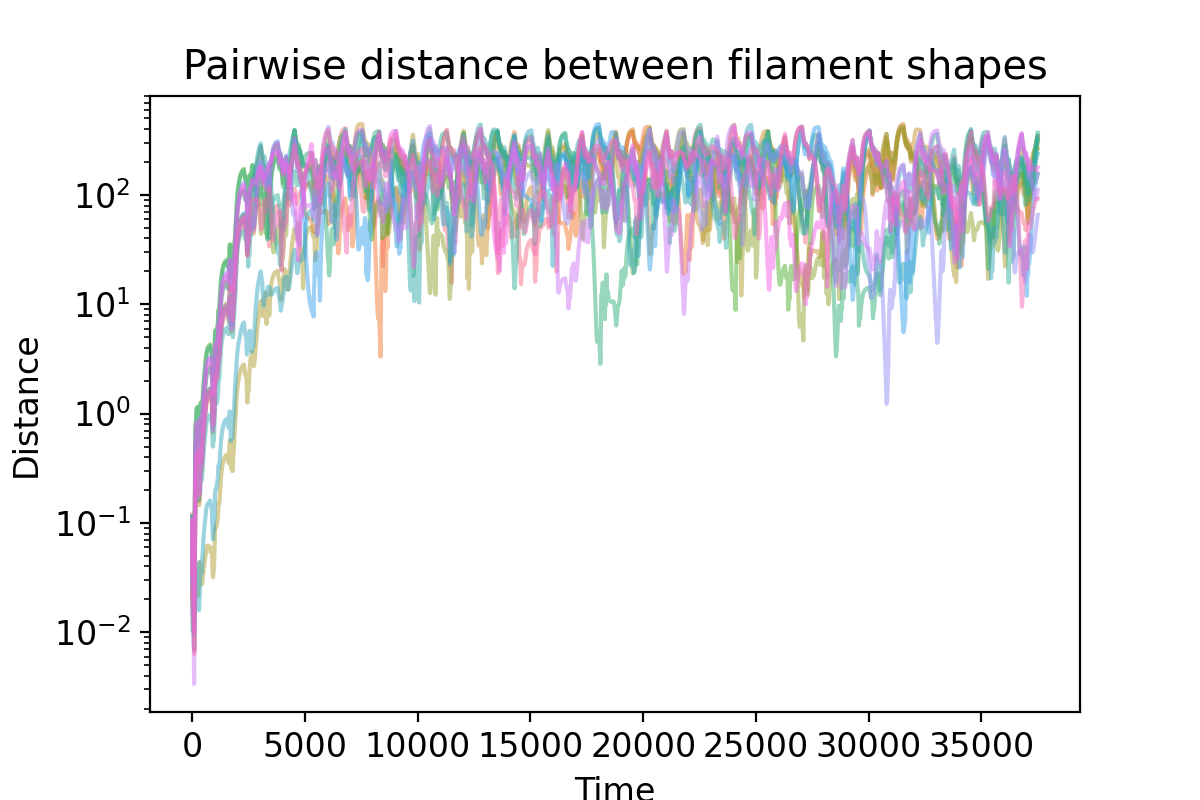

In [181]:
# Plot the pair-wise distance vs time (for all IC pairs)
import seaborn as sns

note = 'period2_lowActivity'
plt.figure(figsize = (6,4))
plt.title('Pairwise distance between filament shapes')
sns.lineplot(x='Time', y = 'Distance', data = pairwise_distance_df, hue = 'IC pair', estimator = None, legend = False, alpha = 0.5)
plt.yscale('log')


# plt.savefig(os.path.join(publication_figures, note+'_'+ 'pairwise_distance'+'.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(publication_figures, file_name + 'pairwise_distance'+'.svg'), dpi = 300, bbox_inches = 'tight')
plt.show()

<IPython.core.display.Javascript object>


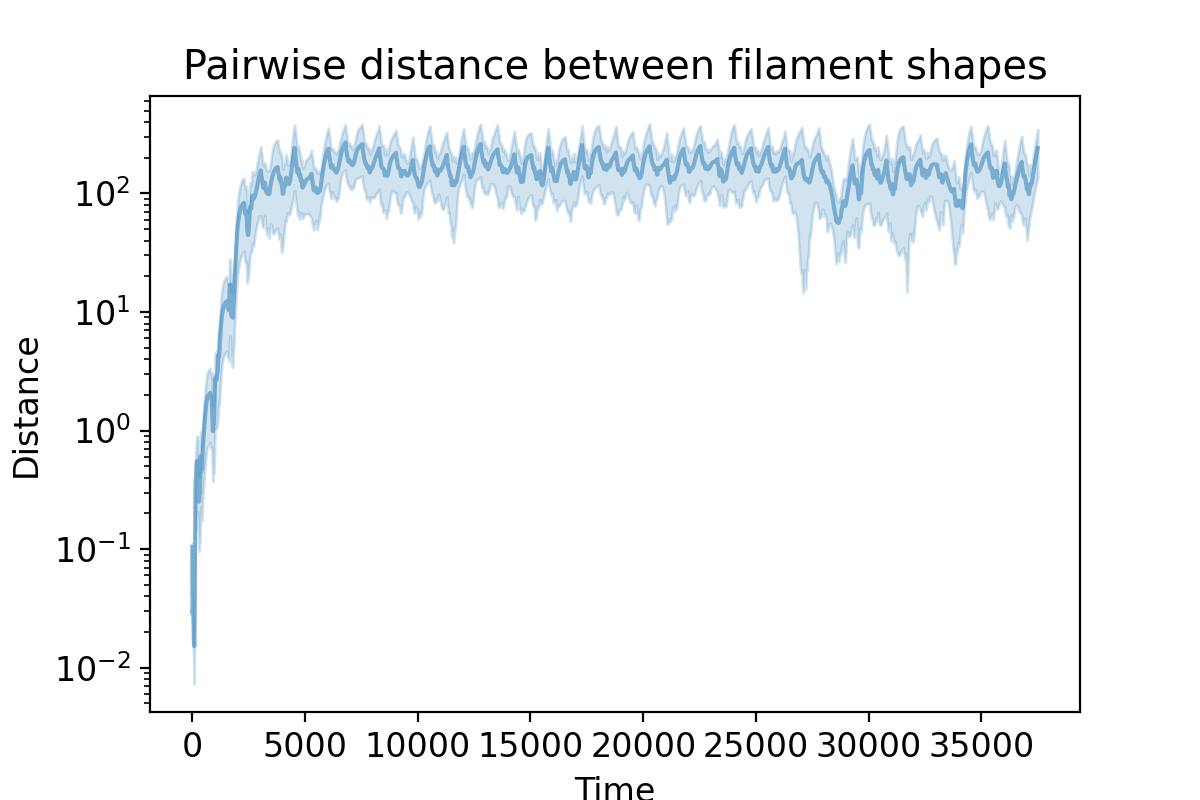

In [194]:
# Plot the mean and CI-95 of the filament pairwise-distance vs Time

note = 'period2_lowActivity'
plt.figure(figsize = (6,4))
plt.title('Pairwise distance between filament shapes')
sns.lineplot(x='Time', y = 'Distance', data = pairwise_distance_df, ci = 'sd', legend = False, alpha = 0.5)
plt.yscale('log')

# Estimate the slope of the Log-linear plot to calculate the Lyapunov exponent.
The averaging order here is important. The Distance vs time data is correlated since it is a time trajectory. We need to account for these correlations when extracting the slope.

We also need to extract the slope for each pair of ICs and then find the average across many different IC pairs and locations along the attractor. 


- For each distinct IC (at different points along the attractor)
    
    - Load the results of simulations at different closely-separated ICs as N*(N-1)/2 distinct pair-wise trajectories.
    
    - estimate the slope/exponent using WLS-ICE and store in an array

- Average the exponent over all IC pairs and all distinct ICs.

- Report the mean and std-dev of this estimate.

In [188]:
# Linear fit
def f(t, params):
    """ Exponential function
    
        y = a*t + b
        
        a = params[0]
        b = params[1]
        
    """
    assert(len(params)==2)
    
    a = params[0]
    b = params[1]
    
    return a*t+b

def df(t, params):
    """Gradient of exponential function.
    gradient(a*exp(b*t)) = [exp(b*t), a*t*exp(b*t)]
    
    
    """
    a = params[0]
    b = params[1]
    
    df_array = np.zeros((len(params), len(t)))
    
    df_array[0] = t
    df_array[1] = 1
    
    return df_array


def d2f(t, params):
    """Hessian of linear function
    """
    a = params[0]
    b = params[1]
    
    d2f_matrix = np.zeros((len(params), len(params), len(t)))
        
    return d2f_matrix

# def f(t, params):
#     """ Exponential function
    
#         a*exp(b*t)
        
#         a = params[0]
#         b = params[1]
        
#     """
#     assert(len(params)==2)
    
#     a = params[0]
#     b = params[1]
    
#     return np.multiply(a, np.exp(b*t))

# def df(t, params):
#     """Gradient of exponential function.
#     gradient(a*exp(b*t)) = [exp(b*t), a*t*exp(b*t)]
    
    
#     """
#     a = params[0]
#     b = params[1]
    
#     df_array = np.zeros((len(params), len(t)))
    
#     df_array[0] = np.exp(b*t)
#     df_array[1] = np.multiply(a*t, np.exp(b*t))
    
#     return df_array


# def d2f(t, params):
#     """Hessian of exponential function
#     """
#     a = params[0]
#     b = params[1]
    
#     d2f_matrix = np.zeros((len(params), len(params), len(t)))
    
#     # d2f/da da
#     d2f_matrix[0,0] = np.zeros(np.shape(t))
    
#     # d2f/ da db
#     d2f_matrix[0,1] = np.multiply(t, np.exp(t))
    
#     # d2f/ db da
#     d2f_matrix[1,0] = d2f_matrix[0,1]
    
#     # d2f/db db
#     d2f_matrix[1,1] = np.multiply(a*np.power(t,2),np.exp(t))
    
    
#     return d2f_matrix
    
    

def load_trajectories(file = None):
    
    """ Returns:
    MxN matrix of trajectory values
        N: number of time points
        M: number of trajectories
    """
  
    
    df = pd.read_csv(file)
    
    time = np.unique(df['Time'])
    diff = time[1:]-time[0:-1]
    
    assert(np.all(diff>0))
    
    start_cycle = 1
    stop_cycle = 5
    activity_timescale = df['activity timescale'][0]
    delta_t = time[1]-time[0]
    start_idx = int(start_cycle*activity_timescale/delta_t)
    stop_idx = int(stop_cycle*activity_timescale/delta_t)
    
    
    time = time[start_idx:stop_idx]

    
    
    unique_conditions = np.unique(df['IC pair'])
    
    M = len(unique_conditions) # No:of trajectories we are analyzing
    N = len(time) # No:of time points
    
    trajectories = np.zeros((M,N))
    
    for ii, condition in enumerate(unique_conditions):
        temp = np.array(df['Distance'][df['IC pair']==condition])
        trajectories[ii, :] = np.log(temp[start_idx:stop_idx])
        
    
    
    return time, trajectories
        
        
        
    
    

In [189]:
file = os.path.join(ic_folder,'Pairwise_distance.csv')

time, trajectories = load_trajectories(file)


## Plot the trajectories

<IPython.core.display.Javascript object>


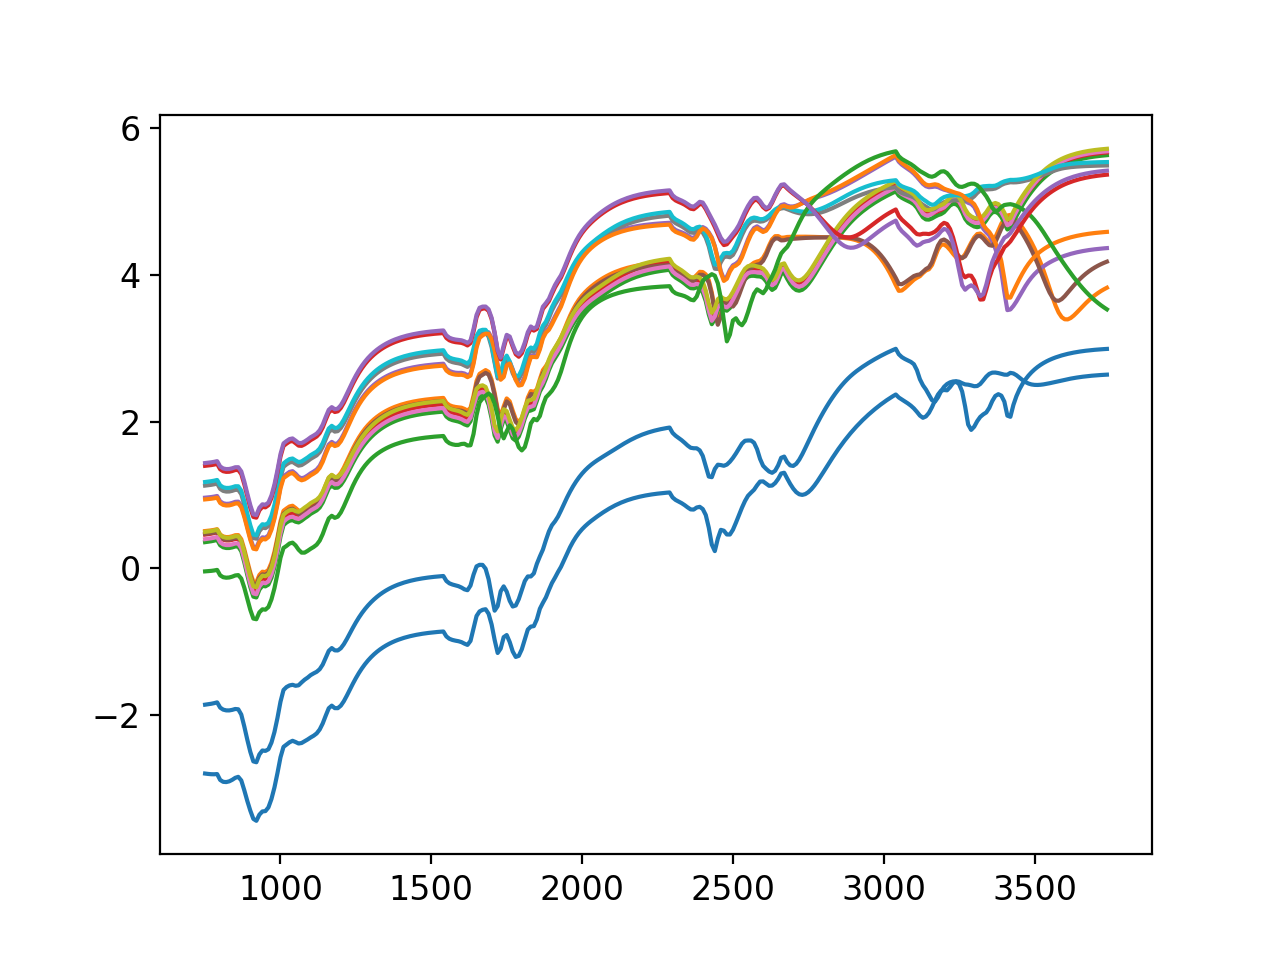

In [190]:
plt.figure()

for ii in range(len(trajectories)):
    
    plt.plot(time, trajectories[ii])
    

# plt.yscale('log')
plt.show()

In [191]:
import wlsice.python.wlsice as wlsice

# The analytical function to fit, its gradient, and hessian
wlsice.init(f, df, d2f)

guess=np.array([1, 1e-2])     # Starting point in parameter space
min_method = "nm"           # Use Nelder-Mead minimization method

params, sigma, chi2_min = wlsice.fit(time, trajectories, guess, min_method)

print("# Optimal param:\t%s" % params)
print("# Sigma:\t%s" % sigma)
print("# Chi-square value: \t%s" % chi2_min)

# Optimal param:	[ 0.00156986 -0.43679879]
# Sigma:	[7.27134746e-05 3.82551718e-01]
# Chi-square value: 	1080.5536335400454


## Plot the data along with the fit


<IPython.core.display.Javascript object>


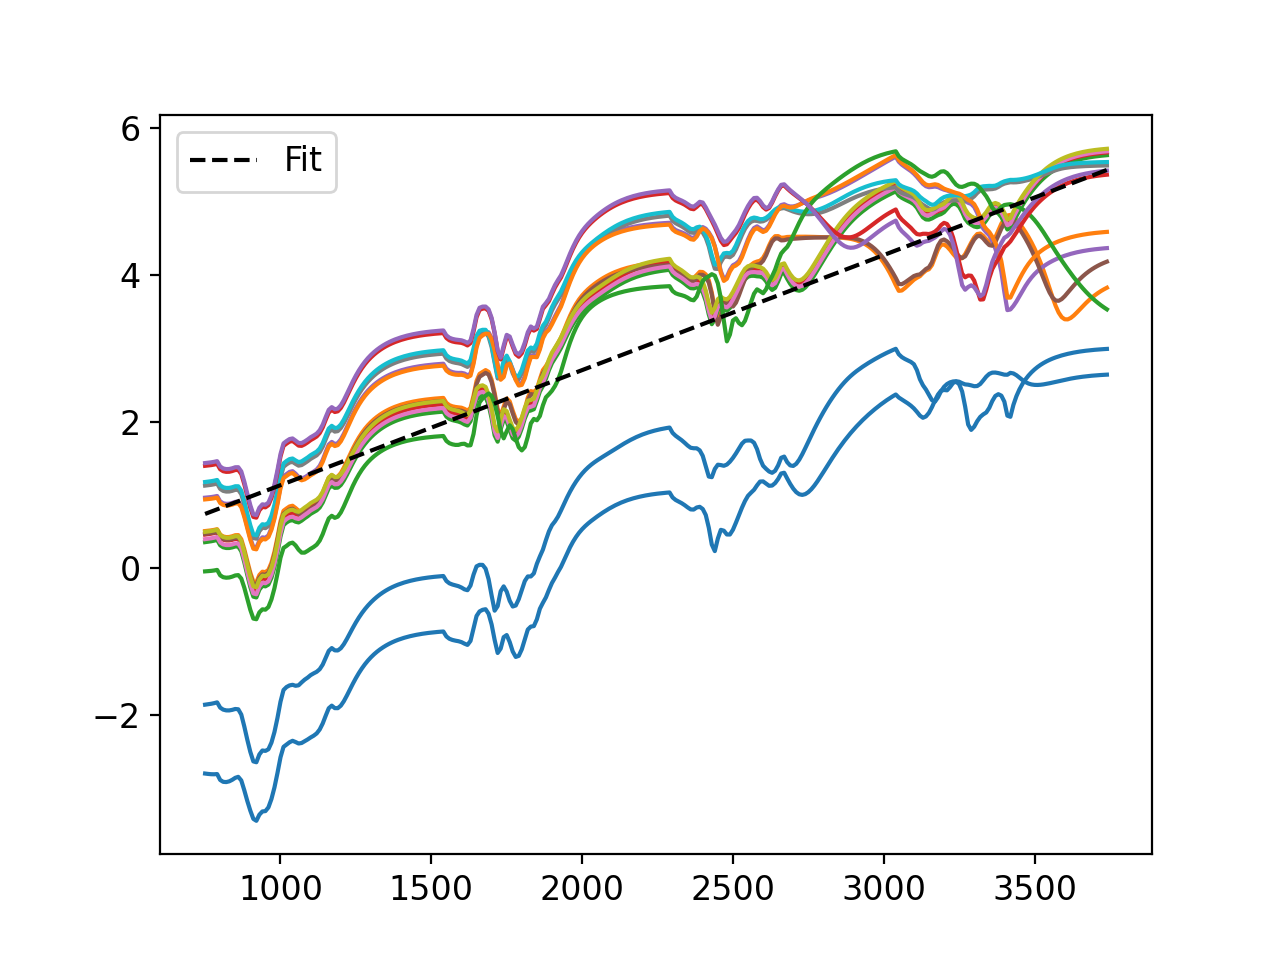

In [192]:
fit_solution = params[0]*time + params[1]

plt.figure()

for ii in range(len(trajectories)):
    
    plt.plot(time, trajectories[ii])
    

plt.plot(time, fit_solution, color = 'k', linestyle = '--', label = 'Fit')
# plt.yscale('log')

plt.legend()
plt.show()

In [193]:
params[0]*750

1.1773923086103508

'sim_data_01'

In [ ]:
# Aperiodic examples
0.2908688349287546

# Periodic examples
-0.4508727750165885
-0.025274483326026095
